In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
import ccgfilt
import pymannkendall as mk

In [ ]:
# Function to extract epoch from the first few rows of the CSV file
def extract_epoch_from_header(file):
    # Read the first few lines to find the epoch (assuming it's in a comment or a header)
    with open(file, 'r') as f:
        skiprow = f.readline()
        skiprow = skiprow.strip().split()[0]
        for line in f:
            if "startdate:" in line.lower():  # Assuming the word 'epoch' is present in the line
                # Extract the epoch date (this assumes the date is the second item in the line)
                epoch = line.strip().split()[1]
                return int(skiprow)-1, epoch[0:4]+"-"+epoch[4:6]+"-"+epoch[6:8]+" "+epoch[8:10]+":"+epoch[10:12]+":"+epoch[12:14]
    return None  # Return None if no epoch is found

# Function to load and adjust time for each CSV
def load_and_adjust_time(file):
    # Try to extract the epoch from the header or a specific column
    nskiprows,epoch = extract_epoch_from_header(file)
   
    if epoch is None:
        raise ValueError(f"Could not find epoch for file: {file}")
   
    # Load the actual data (skipping header if necessary)
    df = pd.read_csv(file, skiprows=nskiprows,sep="\\s+")  # Adjust skiprows based on where the data starts
   
    # Convert 'time' column to a datetime, assuming it's in days
    # Adjust time column to start from the epoch time found in the file
    df['starttime_dt'] = pd.to_timedelta(df['starttime'], unit='D') + pd.Timestamp(epoch)
   
    # Return the adjusted DataFrame
    return df

In [ ]:
#set a working directory till NMVOC folder
working_dir = "C:\\Year1\\"
# Find all CSV files (change the path if nedeed)
prop_files = glob.glob(working_dir+"NMVOC\\Data\\data_EBAS_propane\\*.nas") 
print(prop_files)

# this function reads apropadjust times for all CSV files
dfs = []
for file in prop_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
prop_df = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
print(prop_df)

In [6]:
# Load datasets
df = pd.read_csv("C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv", parse_dates=['datetime'])
df['C3H8_ppt'] = df['C3H8_ppb']*1000
df1=df.drop(columns=["C3H8_ppb"])
df1

,datetime,C3H8_ppt
0,2011-01-05 00:00:00,709.74
1,2011-01-05 02:00:00,785.50
2,2011-01-05 04:00:00,726.28
3,2011-01-05 06:00:00,947.38
4,2011-01-05 08:00:00,743.31
...,...,...
41494,2023-12-31 02:00:00,76.56
41495,2023-12-31 04:00:00,118.15
41496,2023-12-31 05:00:00,106.64
41497,2023-12-31 07:00:00,100.12


In [9]:
# helper columns with  hour, month, year
df1['hour'] = df1['datetime'].dt.hour
df1['month'] = df1['datetime'].dt.month
df1['year'] = df1['datetime'].dt.year
df1['date'] = df1['datetime'].dt.date
df1['day'] = df1['datetime'].dt.dayofyear

In [ ]:
df['date'] = df['starttime_dt'].dt.date
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Function to determine season
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

#season
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
month_to_season 
S=df.starttime_dt.dt.month.map(month_to_season) 
df['season']=S
df

In [ ]:
# matrix of boxplots. Rows: Each row represents a different year.
#Columns: Each column represents a different season (Winter, Spring, Summer, Fall).

# Define the layout for the months according to seasons
seasonal_layout = [
    [12, 1, 2],   # Winter: December, January, February
    [3, 4, 5],    # Spring: March, April, May
    [6, 7, 8],    # Summer: June, July, August
    [9, 10, 11]   # Fall: September, October, November
]

# Define month names for labeling
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# Define years names for labeling
years = np.arange(2011, 2024)

# Create a figure with 4 rows (seasons) and 3 columns (months)
fig, axes = plt.subplots(4, 3, figsize=(24, 12))


# Loop through each subplot position by seasons
for row, season_months in enumerate(seasonal_layout):
    for col, month in enumerate(season_months):
        ax = axes[row, col]
        sns.boxplot(data=df[df['month'] == month], x='year', y='C3H8', ax=ax, fill=False, showmeans=True,meanprops={"marker": "*",
                       "markeredgecolor": "black", "markersize": "10"},boxprops={'color':'black'},
                       medianprops={'color':'red'},whiskerprops={'color':'black'},capprops={'color':'black'}, showfliers=False)
        ax.set_title(month_names[month - 1])
        ax.set_xlabel('Year')
        ax.set_ylabel('C3H8 [ppt]')
        ax.set_ylim(0, 2000)
        # Set major ticks and tick labels
        #ax.set_xticks(range(years))
        #ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
        #ax.set_xticklabels(f"{str(years)[-2:]}", fontsize=10)  # Label years with last two digits 

# Adjust layout for better appearance
cm = 1/2.54  # centimeters in inches
#figure(figsize=(5*cm, 10*cm), dpi=300)
plt.tight_layout()
#plt.show()
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CMN_moth_year.png",dpi=300)


In [ ]:
# matrix of boxplots. Rows: Each row represents a different year.
#Columns: Each column represents a different season (Winter, Spring, Summer, Fall).

# Group data by 'year' and 'season'
grouped = df.groupby(['year', 'season'])

# Get unique years and seasons
years = df['year'].unique()
seasons = df['season'].unique()

# Create subplots - 1 row per year, 1 column for each season
fig, axes = plt.subplots(nrows=len(years), ncols=len(seasons), figsize=(12, len(years) * 4), sharey=True)

# Customize the appearance of the mean as a diamond marker
meanprops = dict(marker='D', markerfacecolor='red', markeredgecolor='black', markersize=8)

# Loop through each year and create a boxplot for each season
for i, year in enumerate(years):
    for j, season in enumerate(seasons):
        ax = axes[i, j]  # Select the correct subplot
        # Filter data for the specific year and season
        season_data = df[(df['year'] == year) & (df['season'] == season)]
        
        # Create a boxplot for this year's season, showing means as diamonds
        ax.boxplot(season_data['C3H8'], showmeans=True,showfliers=False, meanprops=meanprops)
        
        # Set title for each subplot
        ax.set_title(f'{season} {year}')
        
        # Set y-axis label only on the first column
        if j == 0:
            ax.set_ylabel('C3H8 [ppt]')

# Improve layout
plt.tight_layout()
plt.show()


In [ ]:
# Set plot style

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['day'], df['C3H8'], c=df['year'], cmap='viridis', alpha=0.7, s=8, marker='o')

# Add color bar to show which color corresponds to which year
plt.colorbar(scatter, label='year')

# Labels and title
plt.xlabel('Day of Year (2011-2023)')
plt.ylabel('$C_3H_8$ [ppt]')
plt.title('Scatter plot of values by day of the year with colors for years')

# Show plot
plt.show()

In [ ]:
df['year'] = df['starttime_dt'].dt.year

# Group data by 'year'
grouped = df.groupby('year')

# Create subplots (one for each year)
num_years = df['year'].nunique()  # Get unique years count
fig, axes = plt.subplots(nrows=num_years, ncols=1, figsize=(6, num_years * 4))

# Ensure axes is iterable even if there's only one plot
if num_years == 1:
    axes = [axes]


# Plot scatter plot for each year in its subplot
for (year, group), ax in zip(grouped, axes):
    ax.scatter(group['starttime_dt'], group['C3H8'])
    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Propane [ppt]')

plt.tight_layout()
plt.show()

In [ ]:
np.max(df["C3H8"])

In [ ]:


# Define a custom order for the months (Jan, Feb, ..., Dec)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='C3H8', hue='year', order=month_order, palette='tab20', showmeans=True,
            meanprops={"marker":"D", "markerfacecolor":"red", "markeredgecolor":"black"})

# Customize the plot
plt.title('Monthly Boxplots Grouped by Year (2011-2023) with Mean as Diamond', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('C3H8', fontsize=12)

# Adjust the legend
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Extract unique years from the dates in column 'B'
years = df['date'].dt.year.unique()

# Create a dictionary to store sub-datasets for each year
sub_datasets = {}

# Loop through each year and filter the data between 1st Jan and 31st Dec
for year in years:
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    
    # Filter the data for the current year
    sub_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    
    # Store the filtered dataset (only column A and B) in the dictionary
    sub_datasets[year] = sub_data[['C3H8', 'date']]

# Now, sub_datasets contains a sub-dataset for each year
for year, sub_data in sub_datasets.items():
    print(f"Data for {year}:\n{sub_data}\n")



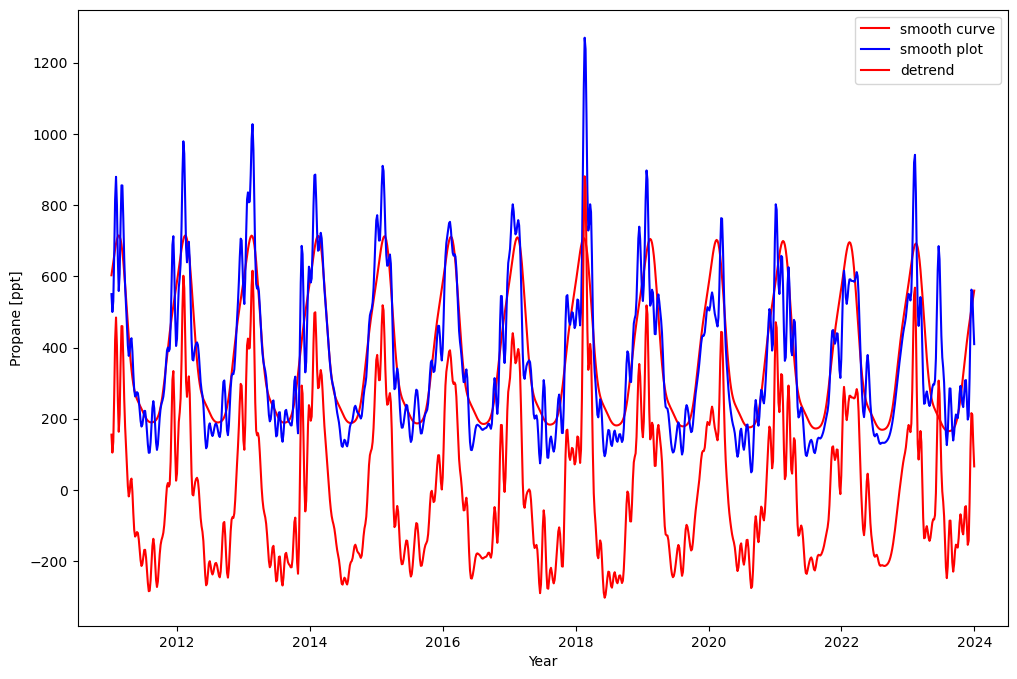

'\n\nplt.plot(x0,detrend,"red",label="detrend")\nplt.xlabel("Year")\nplt.ylabel("Propane(pmol/mol)")\nplt.legend()\nplt.savefig("co2_detrend.png", dpi=300)\nplt.show()\n'

In [18]:

df1 = df1.dropna()
df1["index"] = [i for i in range(len(df))]
df1 = df1.set_index('index')
#print(CO2_df.head())
df1['decimal_date']= [df1["datetime"][i].year+ (df["datetime"][i].dayofyear-1 + df["datetime"][i].hour/24) /365 for i in range(len(df))]

xp = df1['decimal_date']
yp = df1['C3H8_ppt']

#print(xp[0:10])
filt = ccgfilt.ccgFilter(xp, yp, shortterm=30, longterm = 667, sampleinterval=0, numpolyterms=3, numharmonics=4, timezero=-1, gap = 1, debug=False)
#
mm = filt.getMonthlyMeans()
amps = filt.getAmplitudes()
tcup, tcdown = filt.getTrendCrossingDates()

# get x,y data for plotting
x0 = filt.xinterp
y1 = filt.getFunctionValue(x0)
y2 = filt.getPolyValue(x0)
y3 = filt.getSmoothValue(x0)
y4 = filt.getTrendValue(x0)
# Seasonal Cycle
# x and y are original data points
trend = filt.getTrendValue(x0)
detrend = y3 - trend
harmonics = filt.getHarmonicValue(x0)
smooth_cycle = harmonics + filt.smooth - filt.trend
# residuals from the function
resid_from_func = filt.resid
# smoothed residuals
resid_smooth = filt.smooth
# trend of residuals
resid_trend = filt.trend
# residuals about the smoothed line
resid_from_smooth = filt.yp - filt.getSmoothValue(xp)
# equally spaced interpolated data with function removed
x1 = filt.xinterp
y9 = filt.yinterp

plt.figure(figsize=(12,8))
#plt.plot(xp,yp,"*",markersize=4,markeredgecolor="k", markerfacecolor="none", linewidth=1,  label="observations")
plt.plot(x0,y1,"red",label="smooth curve")
plt.plot(x0,y3,"blue",label="smooth plot")
#plt.plot(x0,y4,"orange")
#plt.plot(x0,trend,"green",label="trend curve")
plt.xlabel("Year")
plt.ylabel("Propane [ppt]")
plt.plot(x0,detrend,"red",label="detrend")
plt.legend()
plt.xlim(2010.5,2024.5)
#plt.ylim(300,450)
#plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CMN_trend.png", dpi=300)
plt.show()
'''

plt.plot(x0,detrend,"red",label="detrend")
plt.xlabel("Year")
plt.ylabel("Propane(pmol/mol)")
plt.legend()
plt.savefig("co2_detrend.png", dpi=300)
plt.show()
'''




In [ ]:

#Da controllare, non funziona



# Generate time series data (every 2 hours from 2011-01-01 to 2017-12-31)
date_range = pd.date_range(start='2011-01-01', end='2017-12-31', freq='2H')

# Calculate trend values for each timestamp
trend_values = np.array([trend(x) for x in date_range])

# Create a pandas DataFrame for time and trend
df = pd.DataFrame({'Timestamp': date_range, 'Trend': trend_values})

# Set the Timestamp as the index
df.set_index('Timestamp', inplace=True)

# Calculate the first derivative using a finite difference method (Central Difference)
# Since data is at 2-hour intervals, h = 2 hours
h = 6  # 2 hours
df['Trend_derivative'] = (df['Trend'].shift(-1) - df['Trend'].shift(1)) / (2 * h)

# Drop rows where derivative cannot be calculated (edges)
df.dropna(inplace=True)

# Plot the trend and its first derivative
plt.figure(figsize=(14, 7))

# Plot the trend
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Trend'], label='Trend', color='blue')
plt.title('Trend Over Time')
plt.ylabel('Trend Value')
plt.legend()

# Plot the first derivative of the trend
plt.subplot(2, 1, 2)
plt.plot(df.index, df['Trend_derivative'], label='Trend Derivative', color='red')
plt.title('First Derivative of the Trend')
plt.ylabel('Derivative Value')
plt.xlabel('Time')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_smooth_c = pd.DataFrame(np.array([np.array([int(x) for x in x0]),y1]).T,columns=["time","y1"])
df_smooth_c

In [ ]:
#calculate relativce difference between max and min for each year

# Group by 'year' and calculate max and min for each year
grouped = df_smooth_c.groupby('time')['y1']

# Calculate relative difference for each year
relative_differences = grouped.agg(lambda x: (x.max() - x.min())*100 / x.max())


# Display the result
print(relative_differences)

In [ ]:
relative_differences.min()

In [ ]:
relative_differences.max()

In [ ]:
grouped.agg(['min', 'max'])

In [ ]:

slope, intercept, r_value, p_value, std_err = stats.linregress(relative_differences.index,relative_differences)
slope_theil, intercept_theil, low_slope_theil, high_slope_theil = stats.theilslopes(relative_differences, relative_differences.index,0.99)
res_theil=(slope_theil, intercept_theil, low_slope_theil, high_slope_theil)
res_theil

In [ ]:
slope


In [ ]:
r_value*r_value

In [ ]:
p_value

In [ ]:
regression_line = slope * relative_differences.index + intercept
reg_line_theil = slope_theil * relative_differences.index + intercept_theil
low_reg_line_theil = low_slope_theil * relative_differences.index + intercept_theil
high_reg_line_theil = high_slope_theil * relative_differences.index + intercept_theil 

In [ ]:
low_reg_line_theil

In [ ]:
(relative_differences).plot(style='o')
plt.plot(relative_differences.index, regression_line, color='red', label=f'Fit line: y={slope_theil:.2f}x+{intercept_theil:.2f}')
#plt.plot(relative_differences.index, reg_line_theil, color='red', label=f'Fit line: y={slope_theil:.2f}x+{intercept_theil:.2f}')
#plt.plot(relative_differences.index, low_reg_line_theil, color='red', linestyle='dashed',linewidth=2, label=f'Fit line: y={low_slope_theil:.2f}x+{intercept_theil:.2f}')
#plt.plot(relative_differences.index, high_reg_line_theil, color='red', linestyle='dashed',linewidth=2, label=f'Fit line: y={high_slope_theil:.2f}x+{intercept_theil:.2f}')
plt.ylim(70,80)
plt.xlim(2010.5,2023.5)
plt.ylabel("Relative amplitude [%]")
plt.xlabel("Time")
plt.savefig("C:\\YEAR1\\NMVOC\\code\\figures\\c3h8_CMN_relative_ampl.png", dpi=300)
plt.legend()
plt.show()

In [ ]:
#Mann Kendal test per year

df_trend = pd.DataFrame(np.array([np.array([int(x) for x in x0]),y1]).T,columns=["time","trend"])

df_trend_MK=df_trend.groupby('time')['trend'].agg(mk.original_test).reset_index()
param_cols='trend h p z Tau s var_s slope intercept'.split()
df_trend_MK[param_cols]=[row for row in df_trend_MK['trend']]
df_trend_MK



In [ ]:
len(df_trend_MK.time)

In [ ]:
result_MK = mk.original_test(df_trend.trend)
result_MK

In [ ]:
#Mann Kendall test in the time range 2011-2023

result_MK = mk.original_test(df_trend.trend)
result_MK
#plot


fig, ax = plt.subplots(figsize=(12, 8))
trend_line = np.arange(len(df_trend_MK.time)) * result_MK.slope + result_MK.intercept

ax.plot(x0, trend)
ax.plot(df_trend_MK.time, trend_line)
ax.legend(['data', 'trend line'])

In [ ]:
param_cols='trend h p z Tau s var_s slope intercept'.split()
df_trend_MK[param_cols]=[row for row in df_trend_MK['trend']]
df_trend_MK

In [ ]:
#test with dataset from paper by Angot et al. 2021 
# #https://doi.org/10.5194/acp-21-15153-2021

#set a working directory till NMVOC folder
working_dir = "C:\\Year1\\"
# Find all CSV files (change the path if nedeed)
prop_files = glob.glob(working_dir+"NMVOC\EBAS_propane\\*.nas") 
print(prop_files)

# this function reads apropadjust times for all CSV files
dfs = []
for file in prop_files:
    df = load_and_adjust_time(file)
    dfs.append(df)

# concatenates all DataFrames (based on time)
prop_df = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
print(prop_df)

In [ ]:
#set a working directory till NMVOC folder
working_dir = "C:\\Year1\\"
# Find all CSV files (change the path if nedeed)
prop_files = glob.glob(working_dir+"NMVOC\\fitting_test\\sum_instaar_nmhc_2017.txt\\*.nas") 
print(prop_files)

# this function reads apropadjust times for all CSV files
dfs = []
for file in prop_files:
    df_lit = load_and_adjust_time(file)
    dfs.append(df_lit)

# concatenates all DataFrames (based on time)
df_lit = pd.concat(dfs).sort_values('starttime_dt').reset_index(drop=True)

# Show combined DataFrame
print(df_lit)

In [ ]:
#test with dataset from paper by Angot et al. 2021 
# #https://doi.org/10.5194/acp-21-15153-2021
df_lit = pd.read_csv('C:\\YEAR1\\NMVOC\\code\\fitting_test\\sum_instaar_nmhc_2017.txt', delimiter = "\t")
df_lit = df[df.propane != 99999.999]
df_lit=df_lit[df_lit.propane_numflag != 0.999]
df_lit

In [ ]:
#test with dataset from paper by Angot et al. 2021 
# #https://doi.org/10.5194/acp-21-15153-2021
#select given time range
min_date = df_lit['starttime'].min()
min_date = df_lit['starttime'].min()
max_date = df_lit['starttime'].max()
print(min_date)
print(max_date)
df_lit = df_lit[(df_lit['starttime'] > 2012.000) & (df_lit['starttime'] <= 2018.000)]
df_lit

In [ ]:
#test with dataset from paper by Angot et al. 2021 
# #https://doi.org/10.5194/acp-21-15153-2021
df_lit = df_lit.dropna()
df_lit["index"] = [i for i in range(len(df))]
df_lit = df_lit.set_index('index')
#print(CO2_df.head())
#df['starttime']= [df["starttime_dt"][i].year+ (df["starttime_dt"][i].dayofyear-1 + df["starttime_dt"][i].hour/24) /365 for i in range(len(df))]

xp = df_lit['starttime']
yp = df_lit['propane']

#print(xp[0:10])
filt = ccgfilt.ccgFilter(xp, yp, shortterm=30, longterm = 365, sampleinterval=0, numpolyterms=3, numharmonics=4, timezero=-1, gap = 1, debug=False)
#
mm = filt.getMonthlyMeans()
amps = filt.getAmplitudes()
tcup, tcdown = filt.getTrendCrossingDates()

# get x,y data for plotting
x0 = filt.xinterp
y1 = filt.getFunctionValue(x0)
y2 = filt.getPolyValue(x0)
y3 = filt.getSmoothValue(x0)
y4 = filt.getTrendValue(x0)
# Seasonal Cycle
# x and y are original data points
trend = filt.getTrendValue(x0)
detrend = y3 - trend
harmonics = filt.getHarmonicValue(x0)
smooth_cycle = harmonics + filt.smooth - filt.trend
# residuals from the function
resid_from_func = filt.resid
# smoothed residuals
resid_smooth = filt.smooth
# trend of residuals
resid_trend = filt.trend
# residuals about the smoothed line
resid_from_smooth = filt.yp - filt.getSmoothValue(xp)
# equally spaced interpolated data with function removed
x1 = filt.xinterp
y9 = filt.yinterp


#plt.plot(xp,yp,"bo",markersize=3,markeredgecolor="k",label="observations")
#plt.plot(x0,y1,"red",label="smooth curve")
#plt.plot(x0,y3,"blue",label="smooth plot")
plt.plot(x0,y4,"orange")
plt.plot(x0,trend,"green",label="trend curve")
plt.xlabel("Year")
plt.ylabel("Propane(pmol/mol)")
#plt.plot(x0,detrend,"red",label="detrend")
plt.legend()
#plt.savefig("co2_trend.png", dpi=300)
plt.show()

In [ ]:
res = stats.theilslopes(x, y, 0.90, method='separate')
lsq_res = stats.linrgeress(x,y)
res
